# Problem Statement

We are interested in revealing the most significant cost drivers in the construction of a desalination plant.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',160)

# Data Inspection and Cleaning

In [2]:
#load and inspect top few rows
raw_df = pd.read_excel('data/raw.xlsx')
raw_df.head(4)

,Country,Region,Subregion,Location,State/Region,Location type,Project name,Capacity (m3/d),Size,Capacity (MGD),Capacity (MIGD),Units,Unit size (m3/d),Unit size (MGD),Unit size (MIGD),Technical notes,Technology,Primary Reuse Sector,Thermal design,Thermal equipment,Membrane supplier (RO),Membrane type (RO),ERD supplier,ERD type,DAF pretreatment supplier,DAF brand,MF/UF Pretreatment Supplier,MF/UF brand,Other pretreatment,Feedwater,Award date,Online date,Consultant,Consultant 2,Consultant 3,Customer type,Industry,Customer,Plant status,Plant type,Plant supplier,Plant supplier share,Plant supplier 2,Plant supplier 2 share,Plant supplier 3,Plant supplier 3 share,Plant supplier 4,Plant supplier 4 share,Plant supplier 5,Plant supplier 5 share,Procurement model,Concession period,Dev consortium,Developer,Dev share,Developer 2,Dev2 share,Developer 3,Dev3 share,Developer 4,Dev4 share,Developer 5,Dev5 share,Developer 6,Dev6 share,EPC price,Water price (USD/m3),Last update,Contact,Feedwater Ph,Feedwater salinity,Feedwater temp minimum,Feedwater temp maximum,Product water salinity,Product water temp,Civil contractor (off-shore),Civil contractor (on-shore),Consultant.1,Developer/co-developer,ED/EDR system supplier,Engineering Consultancy,Environmental advisor,EPC contractor (desal),EPC contractor (pipeline),EPC contractor (power),EPCM contractor,Equipment Supplier : Desal (unspecified),Equipment supplier : Membranes (Not specified / Other),Equipment Supplier: Chemical Feed System,Equipment Supplier: Energy Recovery Device,Equipment Supplier: Glass Reinforced Polyester Pipes and Fittings,Equipment Supplier: High Pressure Pipe Materials,Equipment Supplier: Low Pressure Pipe Materials,Equipment Supplier: Membranes ( NF ),Equipment Supplier: Membranes ( UF ),Equipment Supplier: Motors,Equipment Supplier: Pipes (unspecified),Equipment Supplier: Pressure vessels,Equipment supplier: Pretreatment (DAF),Equipment Supplier: Pretreatment (Other),Equipment Supplier: Pumps: Brine circulation (concentrate disposal),Equipment Supplier: Pumps: Brine circulation (recirculation - MSF only),Equipment Supplier: Pumps: High pressure,Equipment Supplier: Pumps: Not specified/other,Equipment Supplier: Steel,Equipment Supplier: Valves,Financial advisor,Government agency,Holding Company,Insurance adviser,Legal advisor,Lender,Lender engineer,O&M contractor,Off-taker,Owners engineer,Plant owner,Prime contractor,Project Company,Subcontractor,Technical advisor,Technology provider,Winner,Short listed,Bid submitted,Pre qualified,Statement of qualification,RO System,RO Configuration,RO Feed Pump Drive,RO Control Type,RO Energy Recovery,RO Electrical Power Consumption,RO Membrane Type,RO Pre Treament 1st Stage,RO NPS Or MWCO,RO Pre Treament 2nd Stage,RO Pre Treament 3rd Stage,RO Pre Treament 4th Stage,RO Pre Treament 5th Stage,RO Passivation,RO Disinfection,RO Dosed Chemical 1st Stage,MED Design,MED System,MED Equipment,MED Type,MED Geometry,MED Configuration,MED Power Consumption,MED Gain Output Ratio,MSF Design,MSF System,MSF Equipment,MSF Type,MSF Geometry,MSF Configuration,MSF Heat Recovery Stages,MSF Heat Rejection Stages,MSF Gain Output Ratio
0,Afghanistan,Asia Pacific,Southern Asia,Afghanistan,NaN,Land based,Afghanistan,227.0,S,0.06,0.05,1.0,227.0,0.06,0.05,NaN,RO (Reverse Osmosis),NaN,NaN,NaN,NaN,Spiral Wound Membrane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brackish water or inland water (TDS 3000ppm - ...,2006.0,2007.0,NaN,NaN,NaN,Military purposes (TDS 10ppm- <1000ppm),NaN,NaN,Online,NaN,Corodex Industries,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 14:23:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Corodex Industries,NaN,NaN,NaN,NaN,"Toray Industries, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Concorde-Corodex Group,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spiral Wound Membrane,NaN,NaN,NaN,NaN,N

In [3]:
raw_df.shape

(21932, 160)

The target variable, EPC Price is our most important variable. Only records with non-missing price entries will be considered.

In [4]:
#get number of entries and columns
df = raw_df[raw_df['EPC price'].notna()]
df.shape

(10314, 160)

Let's see the percentage of missing values for each column in the dataframe.

In [5]:
missing = df.isna().sum()*100/df.shape[0]
missing.sort_values(ascending=False)

ED/EDR system supplier                                                     100.0
Equipment Supplier: Pumps: Brine circulation (recirculation - MSF only)    100.0
Equipment Supplier: Pumps: Brine circulation (concentrate disposal)        100.0
Equipment Supplier: Low Pressure Pipe Materials                            100.0
Insurance adviser                                                          100.0
                                                                           ...  
Region                                                                       0.0
EPC price                                                                    0.0
Plant status                                                                 0.0
Technology                                                                   0.0
Country                                                                      0.0
Length: 160, dtype: float64

Let's drop columns with over 90 percent missing values

In [6]:
to_drop = missing[missing>90].index
df = df.drop(to_drop,axis=1)
df.shape

(10314, 40)

This leaves us with about 25 percent of the initial columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 4 to 21928
Data columns (total 40 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Country                                                 10314 non-null  object        
 1   Region                                                  10314 non-null  object        
 2   Subregion                                               10314 non-null  object        
 3   Location                                                9502 non-null   object        
 4   State/Region                                            3077 non-null   object        
 5   Location type                                           10305 non-null  object        
 6   Project name                                            10313 non-null  object        
 7   Capacity (m3/d)                                         10

- There are 3 location variables with no missing values. Dropping the **State/region** variable might not hurt our model 
- The **Unit Size** and **Capacity** variables appear to be repeated with diffent units
- Variables like **thermal design**, **industry**, and **water salinity** have too many missing values.
- **EPC price** is an object variable. 

In [8]:
df['EPC price'].sample(5)

4730        40,000 USD
7925       910,000 USD
15327    6,190,000 USD
5358     1,470,000 USD
2256     3,170,000 USD
Name: EPC price, dtype: object

Let's confirm that we have consistent currencies

In [9]:
df['EPC price'].str.split(expand=True)[1].unique()

array(['USD', 'QAR', 'EUR', 'JOD', 'BRL', 'INR', 'SGD', 'CNY', 'TWD',
       'MAD', 'SAR', 'OMR'], dtype=object)

We'll need to convert the prices to a base currency (USD/EUR). 

In [10]:
#extract currency
df['currency'] = df['EPC price'].str.split(expand=True)[1]

#extract price value
df['EPC price'] = df['EPC price'].str.split(expand=True)[0].str.replace(',','')

#convert EPC Price to numeric
df['EPC price'] = pd.to_numeric(df['EPC price'])

#get unique currencies
symbols = df['currency'].unique()

In [11]:
#get current exchange rate for each currency
import requests, os, json
from resources import api_key
KEY = api_key.KEY
base = 'USD'
symbols = ','.join(symbols)
url = f"https://api.apilayer.com/fixer/latest?base={base}&symbols={symbols}&apikey={KEY}"

if 'rates.json' in os.listdir('resources'):
    with open("resources/rates.json", "r") as f:
        rates = json.load(f)
else:
    resp = requests.get(url)
    rates = resp.json()['rates']
    with open("resources/rates.json", "w") as f:
        json.dump(rates, f)

In [12]:
rates

{'USD': 1,
 'QAR': 3.64104,
 'EUR': 1.019905,
 'JOD': 0.709027,
 'BRL': 5.415887,
 'INR': 81.856899,
 'SGD': 1.434697,
 'CNY': 7.115982,
 'TWD': 31.881197,
 'MAD': 10.95103,
 'SAR': 3.75772,
 'OMR': 0.38505}

In [13]:
#convert prices
df['epc_price(usd)'] = df.apply(lambda x: round(x['EPC price']/rates[x['currency']],2),axis=1 )

In [14]:
#make column names and string values consistent
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')
for column in df.select_dtypes(include='O').columns:
    if column != 'country':
        df[column] = df[column].str.lower()

In [15]:
#get stats about numeric columns
df.describe()

,capacity_(m3/d),capacity_(mgd),capacity_(migd),units,unit_size_(m3/d),unit_size_(mgd),unit_size_(migd),award_date,online_date,plant_supplier_share,epc_price,product_water_salinity,epc_price(usd)
count,10311.000000,10311.000000,10311.000000,10102.000000,10099.000000,10099.000000,10099.000000,10313.000000,10308.000000,9182.000000,1.031400e+04,1105.000000,1.031400e+04
mean,5597.808554,1.478987,1.231298,1.788656,1569.845008,0.414838,0.345149,1988.509357,1989.356907,98.494768,9.923041e+06,24.561267,8.612353e+06
std,32052.868682,8.468442,7.050852,7.984676,4920.409954,1.299952,1.082488,11.244649,11.147720,8.902144,9.489007e+07,110.949940,6.414724e+07
min,8.000000,0.000000,0.000000,1.000000,14.250000,0.000000,0.000000,1944.000000,1945.000000,0.000000,8.000000e+03,0.000000,8.000000e+03
25%,240.000000,0.060000,0.050000,1.000000,200.000000,0.050000,0.040000,1981.000000,1982.000000,100.000000,2.712500e+05,0.000000,2.712500e+05
50%,550.000000,0.150000,0.120000,1.000000,480.000000,0.130000,0.110000,1990.000000,1990.000000,100.000000,7.200000e+05,0.000000,7.200000e+05
75%,1892.000000,0.500000,0.420000,2.000000,1200.000000,0.320000,0.260000,1997.000000,1998.000000,100.000000,2.320000e+06,0.000000,2.310000e+06
max,909000.000000,240.160000,199.960000,600.000000,140000.000000,36.990000,30.800000,2021.000000,2023.000000,100.000000,4.670000e+09,1500.000000,2.560000e+09


We'll need to scale the numerical variables later on since some of them have a wide range

# EDA

## EPC Price

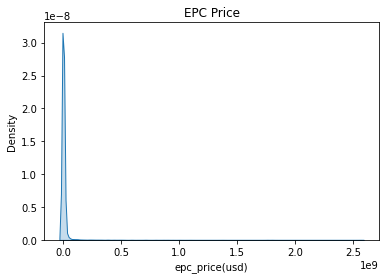

In [16]:
sns.kdeplot(df['epc_price(usd)'],shade=True)
plt.title('EPC Price');

It costs less than **half a billion dollars** to build a lot of plants in the dataset.

Machine learning models could find it difficult to learn properly from a heavily skewed target variable. Let's log transform the price variable

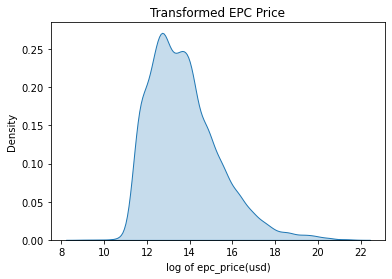

In [17]:
df['log_price'] = np.log1p(df['epc_price(usd)'])
sns.kdeplot(df['log_price'],shade=True)
plt.title('Transformed EPC Price')
plt.xlabel('log of epc_price(usd)');

## Award Date

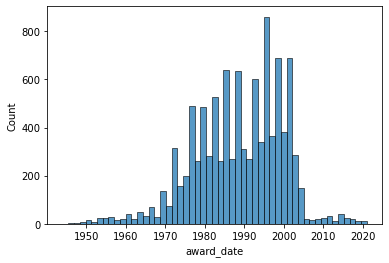

In [18]:
sns.histplot(df.award_date);

Most of the plant contracts were awarded between the late 1900s and early 2000s 

## Award Date and EPC Price

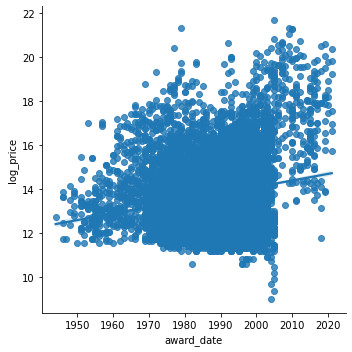

In [19]:
sns.lmplot(x='award_date',y='log_price',data=df);

Older plant contracts typically cost less than more recent plant contracts

## Country

In [20]:
df.country.nunique()

143

The dataset contains plants built in about 143 countries

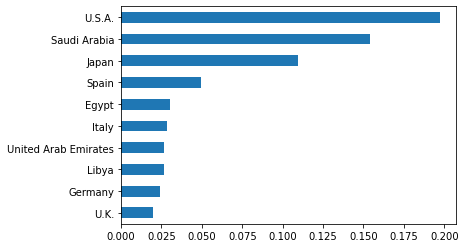

In [21]:
df.country.value_counts(normalize=True,ascending=True)[-10:].plot.barh();

Over **45 percent** of the plants were built in **America and Asia**

## EPC Price and Location

In [22]:
#find average numbber of plants per country
df.country.value_counts().median()

12.0

We'll calculate the average cost to build a plant in countries with at least 12 plants

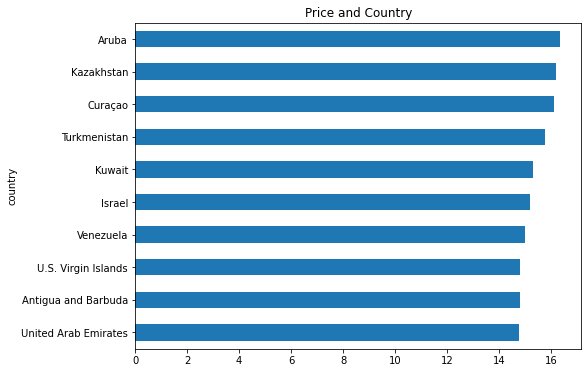

In [23]:
average_prices = df.groupby('country')['log_price'].agg(['mean','count'])

plt.figure(figsize=(8,6))
average_prices[average_prices['count']>=12]['mean'].sort_values()[-10:].plot.barh()
plt.title('Price and Country');

It is more expensive to build a plant in countries with a dry climate, though this is not a strong correlation.

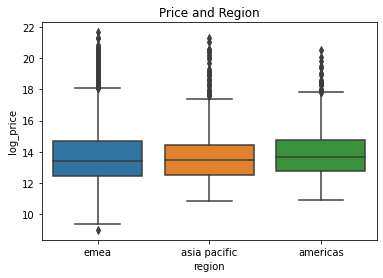

In [24]:
sns.boxplot(x='region',y='log_price',data=df)
plt.title('Price and Region');

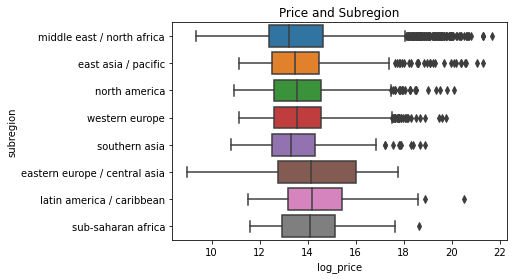

In [25]:
sns.boxplot(y='subregion',x='log_price',data=df)
plt.title('Price and Subregion');

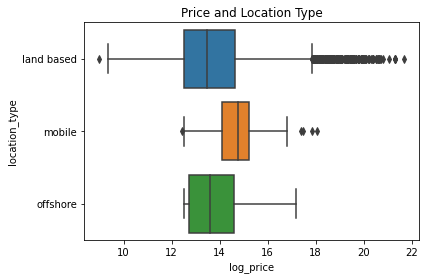

In [26]:
sns.boxplot(y='location_type',x='log_price',data=df)
plt.title('Price and Location Type');

There hasn't been a strong relationship between price and most of the location variables. We'll create another column to record the continent of each country.

In [27]:
df['country'].unique()

array(['Algeria', 'Australia', 'Bahrain', 'Canada', 'Egypt', 'France',
       'Greece', 'India', 'Iran', 'Iraq', 'Italy', 'Japan', 'Jordan',
       'Kazakhstan', 'Libya', 'Mexico', 'Morocco', 'Myanmar', 'Oman',
       'Poland', 'Qatar', 'Saudi Arabia', 'South Korea', 'Spain', 'Syria',
       'U.K.', 'U.S.A.', 'United Arab Emirates', 'Yemen', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Aruba', 'Austria', 'Bahamas',
       'Belgium', 'Belize', 'Chile', 'Denmark', 'Ecuador', 'Germany',
       'Israel', 'Kuwait', 'Netherlands', 'Nigeria', 'Portugal', 'Russia',
       'Saint Helena', 'Sint Maarten', 'South Africa', 'Switzerland',
       'Trinidad and Tobago', 'Turkey', 'Turkmenistan', 'Azerbaijan',
       'Barbados', 'Bermuda', 'Bonaire, Sint Eustatius and Saba',
       'Brazil', 'Cabo Verde', 'China', 'Indonesia', 'Ireland', 'Lebanon',
       'Liechtenstein', 'Malaysia', 'Pakistan', 'Philippines', 'Serbia',
       'Thailand', 'Tunisia', 'British Virgin Islands', 'Bulgaria',
 

Some of the country values are regions. We'll replace these countries with their actual countries. We'll also make the country names consistent

In [28]:
#clean country column
df['country'][(df['country'].str.contains('U.K')) | (df['country'].str.contains('UK'))] = 'United Kingdom'
df['country'][(df['country'].str.contains('U.S')) | (df['country'].str.contains('US'))] = 'United States'

In [29]:
#generate continent 
import pycountry_convert as pc

continents = {}
for country in df['country'].unique():
    try:
        country_code = pc.country_name_to_country_alpha2(country)
        continent = pc.country_alpha2_to_continent_code(country_code) 
        continents[country] = continent
    except:
        print(country)

Antarctica
Saint Helena
Sint Maarten
United States Minor Outlying Islands
Saint Barthelemy


In [30]:
#manually fill the continent values for the unidentified countries
others = {'Antarctica':'Antarctica','Saint Helena':'AF','Sint Maarten':'NA',
         'United States Minor Outlying Islands':'NA','Saint Barthelemy':'NA'}
continents.update(others)

In [31]:
#map each country to their respective continents
df['continent'] = df['country'].map(continents)

#check the resulting unique continents
df['continent'].unique()

array(['AF', 'OC', 'AS', 'NA', 'EU', 'Antarctica', 'SA'], dtype=object)

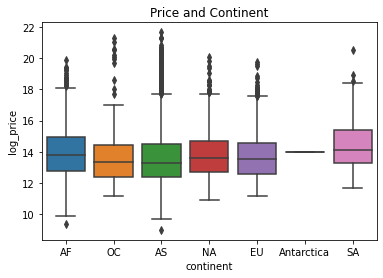

In [32]:
sns.boxplot(x='continent',y='log_price',data=df)
plt.title('Price and Continent');

Maybe location is not as important as we expect it to be

In [33]:
df.thermal_design.value_counts()

flash                                  648
mvc (mechanical vapour compression)    359
tvc (thermal vapor compression)        186
med (pure)                              15
tvc (thermal vapour compression)         1
Name: thermal_design, dtype: int64

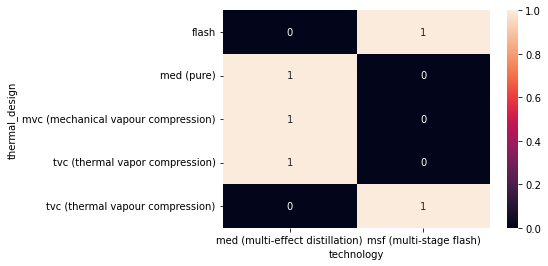

In [34]:
sns.heatmap(pd.crosstab(df.thermal_design,df.technology,normalize='index'),annot=True);

## EPC Price and Numerical Features

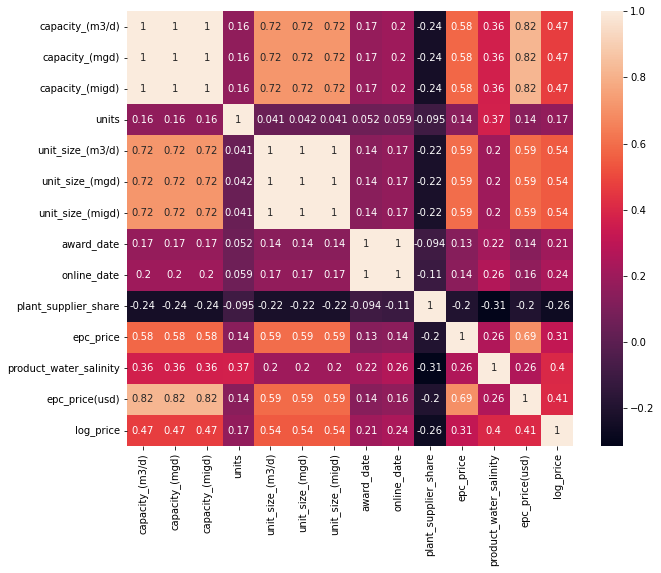

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True);

- The size and capacity of a plant greatly affect its price
- The supplier's share on plant's contract affects its price negatively
- online date and award date are highy correlated

## EPC Price and Size

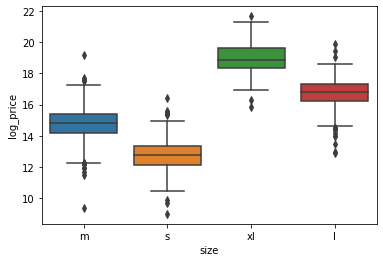

In [36]:
sns.boxplot(x='size',y='log_price',data=df);

Large plants clearly cost more

## EPC Price and Technology

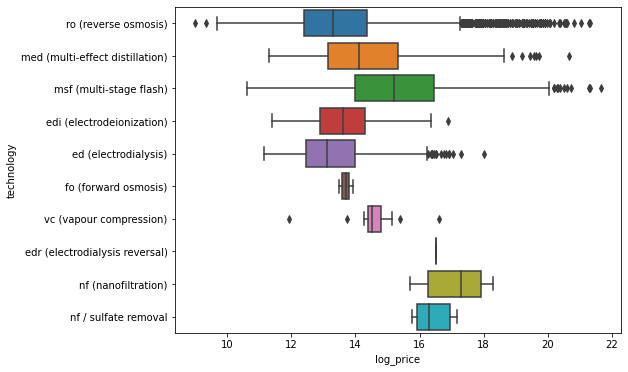

In [37]:
plt.figure(figsize=(8,6))
sns.boxplot(y='technology',x='log_price',data=df);

These technologies can be grouped according to their desalination processes: thermal, membrane, specialized

In [38]:
df['process'] = df['technology'].map({'ro (reverse osmosis)': 'Membrane',
                                        'nf (nanofiltration)': 'Membrane',
                                        'ed (electrodialysis)': 'Membrane',
                                        'edi (electrodeionization)': 'Membrane',
                                        'fo (forward osmosis)': 'Membrane',
                                        'edr (electrodialysis reversal)': 'Membrane',
                                        'nf / sulfate removal': 'Specialized',
                                        'med (multi-effect distillation)': 'Thermal',
                                        'msf (multi-stage flash)': 'Thermal',
                                        'vc (vapour compression)': 'Thermal'})

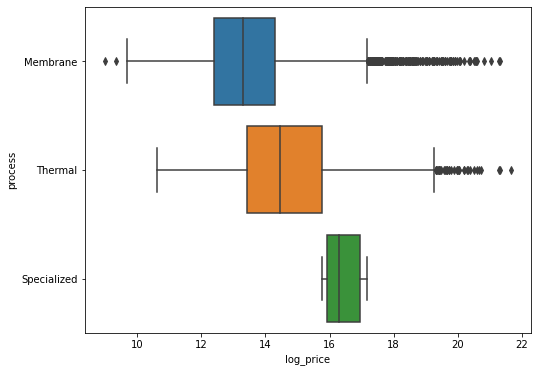

In [39]:
plt.figure(figsize=(8,6))
sns.boxplot(y='process',x='log_price',data=df);

On average, it is more expensive to build a plant that uses specialized method of desalination

## EPC Price and Plant Status

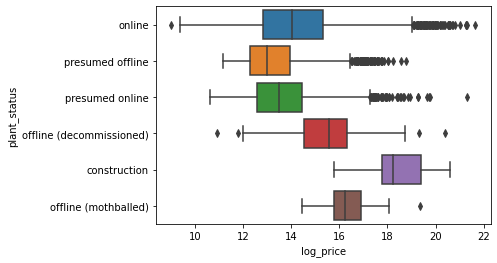

In [40]:
sns.boxplot(y='plant_status',x='log_price',data=df);

Plants under construction tend to cost more. This variable might not be so helpful in predicting a plant's cost since a plant's status can only be known when the construction or operation must have begun

## EPC Price and Plant Type

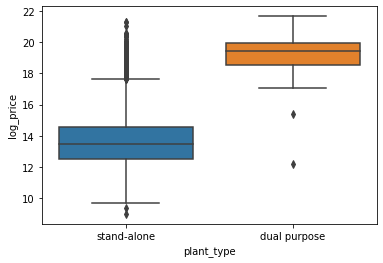

In [41]:
sns.boxplot(x='plant_type',y='log_price',data=df);

Dual purpose plants cost more

## EPC Price and Procurement Model

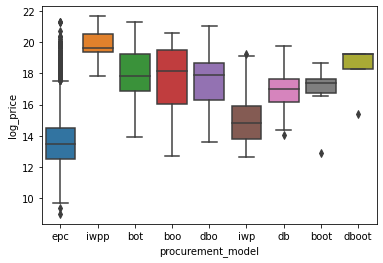

In [42]:
sns.boxplot(x='procurement_model',y='log_price',data=df);

**iwpp** models appear to cost more

## EPC Price and RO System

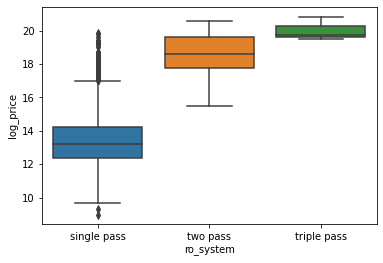

In [43]:
sns.boxplot(x='ro_system',y='log_price',data=df);

EPC Price and **ro_system** are correlated

## EPC Price and RO Feed Pump Drive

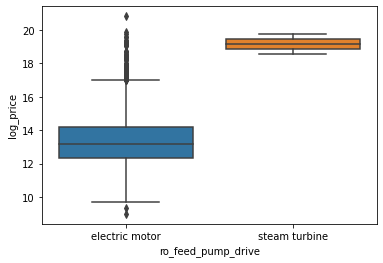

In [44]:
sns.boxplot(x='ro_feed_pump_drive',y='log_price',data=df);

Steam turbine plants are more expensive

## EPC Price and RO Membrane Type

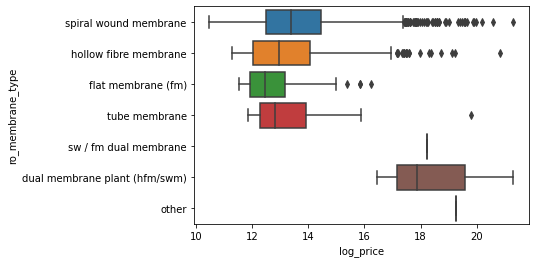

In [45]:
sns.boxplot(y='ro_membrane_type',x='log_price',data=df);

The price of a desalination plant and the type of membrane seem to be related in a measurable way.

Overall, a plant's technical specifications can reveal a lot about its price.

# Data Preprocessing

We'll exclude the following variables in building our model:
- **unit_size**: highly correlated with capacity
- **memebrane_type_(ro)**: same variable as **ro_membrane_type**
- **project_name** : We do not expect name to affect the price of a plant
- **(mgd)**, **(migd)** variables: since these are just unit conversions of the capacity and size variables
- **award_date, online_date, plant_status** : These are not variables we would know beforehand
- **epc_price, currency, epc_price(usd),**: We only need the **log_price** as our target variable

In [46]:
#seperate features from target
X = df[['country', 'region', 'subregion', 'location', 'state/region',
       'location_type', 'capacity_(m3/d)', 'size','units','technology', 'process', 'thermal_design',
        'feedwater','customer_type', 'industry', 'customer', 'plant_type','plant_supplier',
        'plant_supplier_share', 'procurement_model','product_water_salinity','epc_contractor_(desal)',
        'equipment_supplier_:_membranes_(not_specified_/_other)','holding_company', 'plant_owner',
        'bid_submitted', 'ro_system','ro_feed_pump_drive','ro_membrane_type','continent']]
y = df['log_price']

In [47]:
#split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.5, random_state=0)

In [48]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((7219, 30), (1548, 30), (1547, 30), (7219,), (1548,), (1547,))

## Handle Missing Values

To impute the missing values, we'll need to understand if the missing entries were not recorded or they simply do not exist.

- `thermal_design` contains missing values because only plants using thermal processes would have thermal designs
- There are missing values in the `ro` variables because they are specific to plants using reverse osmosis technology

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class CatImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputers = {}
        self.cols = ['location', 'state/region', 'location_type']

    def fit(self, X, y=None):
        for col in self.cols:
            self.imputers[col] = dict(X.groupby('country')[col].apply(lambda group: group.value_counts().idxmax() if group.value_counts().sum() > 0 else np.nan))
        
        self.thermal_design = X[X.process=='Thermal'].thermal_design.mode()[0]
        self.ro_system = X[X.technology=='ro (reverse osmosis)'].ro_system.mode()[0]
        self.ro_feed_pump_drive = X[X.technology=='ro (reverse osmosis)'].ro_feed_pump_drive.mode()[0]
        self.ro_membrane_type = X[X.technology=='ro (reverse osmosis)'].ro_membrane_type.mode()[0]
        
        self.general_imputer = X.mode().iloc[0].to_dict()
        
        return self

    def transform(self, X):
        df = X.copy()
        for col in self.cols:
            df.loc[df[col].isna(), col] = df[df[col].isna()]['country'].map(self.imputers[col])
        
        df.loc[(df.process=='Thermal')&(df.thermal_design.isna()),'thermal_design']=self.thermal_design
        df.loc[(df.technology=='ro (reverse osmosis)')&(df.ro_system.isna()),'ro_system']=self.ro_system
        df.loc[(df.technology=='ro (reverse osmosis)')&(df.ro_feed_pump_drive.isna()),'ro_feed_pump_drive']=self.ro_feed_pump_drive
        df.loc[(df.technology=='ro (reverse osmosis)')&(df.ro_membrane_type.isna()),'ro_membrane_type']=self.ro_membrane_type
        df.loc[:,['thermal_design','ro_system','ro_feed_pump_drive','ro_membrane_type']]=df[['thermal_design','ro_system','ro_feed_pump_drive','ro_membrane_type']].fillna('N/A')

        df.fillna(self.general_imputer,inplace=True)    
        return df

In [50]:
#seperate numerical data from categorical data
num_train = X_train.select_dtypes(exclude='O')
cat_train = X_train.select_dtypes(include='O')

In [51]:
#fill numerical columns with mean and categorical columns with most frequent
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
cat_imputer = CatImputer()

#fill missing values
num_train = pd.DataFrame(num_imputer.fit_transform(num_train),columns = num_train.columns)
cat_train = cat_imputer.fit_transform(cat_train)

## Feature Scaling

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#scale numerical data
num_scaled = scaler.fit_transform(num_train)
num_scaled_df = pd.DataFrame(num_scaled,columns=num_train.columns)

## Categorical Encoding

In [53]:
#explore cat columns
for column in cat_train.columns:
    print(f'{column}: {cat_train[column].nunique()}')

country: 135
region: 3
subregion: 8
location: 2181
state/region: 186
location_type: 3
size: 4
technology: 10
process: 3
thermal_design: 5
feedwater: 6
customer_type: 7
industry: 10
customer: 1518
plant_type: 2
plant_supplier: 486
procurement_model: 9
epc_contractor_(desal): 468
equipment_supplier_:_membranes_(not_specified_/_other): 51
holding_company: 277
plant_owner: 1518
bid_submitted: 448
ro_system: 4
ro_feed_pump_drive: 3
ro_membrane_type: 7
continent: 7


We'll consider columns with not more than 10 categories

In [54]:
not_more_than_10 = [column for column in cat_train.columns if cat_train[column].nunique() <= 10]
cat_train_10 = cat_train[not_more_than_10]

In [55]:
cat_train_10.head()

,region,subregion,location_type,size,technology,process,thermal_design,feedwater,customer_type,industry,plant_type,procurement_model,ro_system,ro_feed_pump_drive,ro_membrane_type,continent
16751,emea,middle east / north africa,land based,s,med (multi-effect distillation),Thermal,flash,seawater (tds 20000ppm - 50000ppm),industry (tds <10ppm),oil & gas,stand-alone,epc,N/A,N/A,N/A,AS
10524,emea,eastern europe / central asia,land based,s,ro (reverse osmosis),Membrane,N/A,pure water or tap water (tds <500ppm),industry (tds <10ppm),power,stand-alone,epc,single pass,electric motor,spiral wound membrane,EU
2598,emea,middle east / north africa,land based,xl,msf (multi-stage flash),Thermal,flash,seawater (tds 20000ppm - 50000ppm),municipalities as drinking water (tds 10ppm - ...,power,stand-alone,epc,N/A,N/A,N/A,AS
16640,emea,middle east / north africa,land based,s,ed (electrodialysis),Membrane,N/A,brackish water or inland water (tds 3000ppm - ...,tourist facilities as drinking water (tds 10pp...,power,stand-alone,epc,N/A,N/A,N/A,AS
18264,asia pacific,east asia / pacific,land based,s,msf (multi-stage flash),Thermal,flash,seawater (tds 20000ppm - 50000ppm),industry (tds <10ppm),power,stand-alone,epc,N/A,N/A,N/A,AS


In [56]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)

#encode categorical data
cat_encoded = encoder.fit_transform(cat_train_10)
cat_encoded_df = pd.DataFrame(cat_encoded,columns=encoder.get_feature_names_out())

In [57]:
#concatenate numerical and categorical data
X_train_preprocessed = pd.concat([num_scaled_df,cat_encoded_df],axis=1)
X_train_preprocessed.columns = X_train_preprocessed.columns.str.replace(' ','_').str.replace(',','_').str.replace('[','_').str.replace(']','_').str.replace('<','_') 
X_train_preprocessed.head()

,capacity_(m3/d),units,plant_supplier_share,product_water_salinity,region_asia_pacific,region_emea,subregion_eastern_europe_/_central_asia,subregion_latin_america_/_caribbean,subregion_middle_east_/_north_africa,subregion_north_america,subregion_southern_asia,subregion_sub-saharan_africa,subregion_western_europe,location_type_mobile,location_type_offshore,size_m,size_s,size_xl,technology_edi_(electrodeionization),technology_edr_(electrodialysis_reversal),technology_fo_(forward_osmosis),technology_med_(multi-effect_distillation),technology_msf_(multi-stage_flash),technology_nf_(nanofiltration),technology_nf_/_sulfate_removal,technology_ro_(reverse_osmosis),technology_vc_(vapour_compression),process_Specialized,process_Thermal,thermal_design_flash,thermal_design_med_(pure),thermal_design_mvc_(mechanical_vapour_compression),thermal_design_tvc_(thermal_vapor_compression),feedwater_brine_or_concentrated_seawater_(tds_>50000ppm),feedwater_pure_water_or_tap_water_(tds__500ppm),feedwater_river_water_or_low_concentrated_saline_water_(tds_500ppm_-__3000ppm),feedwater_seawater_(tds_20000ppm_-_50000ppm),feedwater_wastewater,customer_type_discharge,customer_type_industry_(tds__10ppm),customer_type_irrigation_(tds__1000ppm),customer_type_military_purposes_(tds_10ppm-__1000ppm),customer_type_municipalities_as_drinking_water_(tds_10ppm_-__1000ppm),customer_type_tourist_facilities_as_drinking_water_(tds_10ppm_-__1000ppm),industry_food_&_beverage,industry_general,industry_metals,industry_mining,industry_oil_&_gas,industry_power,industry_pulp_&_paper,industry_refining/chemicals,industry_textiles,plant_type_stand-alone,procurement_model_boot,procurement_model_bot,procurement_model_db,procurement_model_dbo,procurement_model_dboot,procurement_model_epc,procurement_model_iwp,procurement_model_iwpp,ro_system_single_pass,ro_system_triple_pass,ro_system_two_pass,ro_feed_pump_drive_electric_motor,ro_feed_pump_drive_steam_turbine,ro_membrane_type_dual_membrane_plant_(hfm/swm),ro_membrane_type_flat_membrane_(fm),ro_membrane_type_hollow_fibre_membrane,ro_membrane_type_spiral_wound_membrane,ro_membrane_type_sw_/_fm_dual_membrane,ro_membrane_type_tube_membrane,continent_AS,continent_Antarctica,continent_EU,continent_NA,continent_OC,continent_SA
0,-0.163161,-0.095305,0.156561,-0.068234,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.144754,-0.095305,0.156561,-0.068234,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.596954,0.401900,0.156561,-0.068234,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.158530,-0.095305,0.156561,-0.068234,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.160716,-0.095305,0.156561,-0.068234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
import re
def preprocess_1(df,num_imputer,cat_imputer,scaler,encoder):
    #seperate numerical columns from categorical ones
    num_df = df.select_dtypes(exclude='O')
    cat_df = df.select_dtypes(include='O')
    
    #fill missing values
    num_df = pd.DataFrame(num_imputer.transform(num_df),columns = num_df.columns)
    cat_df = pd.DataFrame(cat_imputer.transform(cat_df),columns = cat_df.columns)[not_more_than_10]
    
    #scale numerical data
    num_scaled = scaler.transform(num_df)
    num_scaled_df = pd.DataFrame(num_scaled,columns=num_df.columns)
    
    #encode categorical data
    cat_encoded = encoder.transform(cat_df)
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=encoder.get_feature_names_out())
    
    #concatenate numerical and categorical data
    df_preprocessed = pd.concat([num_scaled_df,cat_encoded_df],axis=1)
    df_preprocessed=df_preprocessed.rename(columns=lambda x: re.sub('[^A-Za-z0-9+]','',x))
    return df_preprocessed

In [59]:
#preprocess val and test sets
X_train_preprocessed = preprocess_1(X_train,num_imputer,cat_imputer,scaler,encoder)
X_val_preprocessed = preprocess_1(X_val,num_imputer,cat_imputer,scaler,encoder)
X_test_preprocessed = preprocess_1(X_test,num_imputer,cat_imputer,scaler,encoder)

In [60]:
X_train_preprocessed.head(3)

,capacitym3d,units,plantsuppliershare,productwatersalinity,regionasiapacific,regionemea,subregioneasterneuropecentralasia,subregionlatinamericacaribbean,subregionmiddleeastnorthafrica,subregionnorthamerica,subregionsouthernasia,subregionsubsaharanafrica,subregionwesterneurope,locationtypemobile,locationtypeoffshore,sizem,sizes,sizexl,technologyedielectrodeionization,technologyedrelectrodialysisreversal,technologyfoforwardosmosis,technologymedmultieffectdistillation,technologymsfmultistageflash,technologynfnanofiltration,technologynfsulfateremoval,technologyroreverseosmosis,technologyvcvapourcompression,processSpecialized,processThermal,thermaldesignflash,thermaldesignmedpure,thermaldesignmvcmechanicalvapourcompression,thermaldesigntvcthermalvaporcompression,feedwaterbrineorconcentratedseawatertds50000ppm,feedwaterpurewaterortapwatertds500ppm,feedwaterriverwaterorlowconcentratedsalinewatertds500ppm3000ppm,feedwaterseawatertds20000ppm50000ppm,feedwaterwastewater,customertypedischarge,customertypeindustrytds10ppm,customertypeirrigationtds1000ppm,customertypemilitarypurposestds10ppm1000ppm,customertypemunicipalitiesasdrinkingwatertds10ppm1000ppm,customertypetouristfacilitiesasdrinkingwatertds10ppm1000ppm,industryfoodbeverage,industrygeneral,industrymetals,industrymining,industryoilgas,industrypower,industrypulppaper,industryrefiningchemicals,industrytextiles,planttypestandalone,procurementmodelboot,procurementmodelbot,procurementmodeldb,procurementmodeldbo,procurementmodeldboot,procurementmodelepc,procurementmodeliwp,procurementmodeliwpp,rosystemsinglepass,rosystemtriplepass,rosystemtwopass,rofeedpumpdriveelectricmotor,rofeedpumpdrivesteamturbine,romembranetypedualmembraneplanthfmswm,romembranetypeflatmembranefm,romembranetypehollowfibremembrane,romembranetypespiralwoundmembrane,romembranetypeswfmdualmembrane,romembranetypetubemembrane,continentAS,continentAntarctica,continentEU,continentNA,continentOC,continentSA
0,-0.163161,-0.095305,0.156561,-0.068234,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.144754,-0.095305,0.156561,-0.068234,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.596954,0.401900,0.156561,-0.068234,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Baseline Model

We need to establish a baseline score for our model(s) to beat. If we were not using machine learning, we'd probably do some sort of aggregation over the data we have. For example, we might choose to aggregate over the size of plant.

In [61]:
#aggregate over train data
agg_prices = df.loc[X_train.index].groupby('size')['epc_price(usd)'].median().to_dict()

In [62]:
from sklearn.metrics import mean_absolute_error as mae
preds = X_val['size'].map(agg_prices)
mae(y_val[preds.notna()],preds[preds.notna()])

5173213.972577262

We have to build a model that beats this score (lesser is better)

# Model Building

In [63]:
# import some models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# import the evaluation function
from sklearn.metrics import mean_absolute_error as mae

In [64]:
# create a list of models
models = [LinearRegression(),
          Lasso(),
          DecisionTreeRegressor(random_state=42),
          RandomForestRegressor(random_state=42),
          ExtraTreesRegressor(random_state=42),
          GradientBoostingRegressor(random_state=42),
          AdaBoostRegressor(random_state=42),
          XGBRegressor(random_state=42),
          LGBMRegressor(random_state=42),
          CatBoostRegressor(random_state=42,verbose=0)
         ]

In [65]:
for model in models:
    model.fit(X_train_preprocessed,y_train)
    val_predictions = model.predict(X_val_preprocessed)
    print(f'{model.__class__.__name__}: {mae(y_val,val_predictions)}') 

LinearRegression: 640947350.1114552
Lasso: 1.2817828550630843
DecisionTreeRegressor: 0.15989341372676888
RandomForestRegressor: 0.14579231338825024
ExtraTreesRegressor: 0.1449496149021294
GradientBoostingRegressor: 0.14714681820077732
AdaBoostRegressor: 0.4205279041280502
XGBRegressor: 0.153187116007014
LGBMRegressor: 0.14358891836755677
CatBoostRegressor: 0.14139779412842532


Overall, the tree-based and boosting algorithms perform better and give similar results.

For reliable results, we'll use cross validation to evaluate the performance of the models . Firstly, we'll string the preprocessing steps.

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# define numerical and categorical columns
num_cols = num_train.columns
cat_cols = cat_train.columns

# define imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = CatImputer()

# define scaler
scaler = StandardScaler()

# define encoder
encoder = ColumnTransformer(transformers=[("encode",
                                           OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False),
                                           not_more_than_10)])

# define column transformer to apply preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num_impute_scale", Pipeline(steps=[("impute", num_imputer),("scale", scaler)]),num_cols),
        ("cat_impute_encode", Pipeline(steps=[("impute", cat_imputer),("encode", encoder)]),cat_cols)])

In [67]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

for model in models:

    # Create a pipeline with the preprocessor and model
    pipe = make_pipeline(preprocessor, model)

    # Perform cross-validation on the pipeline
    scores = -(cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
    print(f'{model.__class__.__name__}: {np.mean(scores)}') 

LinearRegression: 94311963.89918104
Lasso: 1.2647613511729934
DecisionTreeRegressor: 0.17245686794409798
RandomForestRegressor: 0.1489568990272446
ExtraTreesRegressor: 0.1490984016306104
GradientBoostingRegressor: 0.15468696699738685
AdaBoostRegressor: 0.4419801845854042
XGBRegressor: 0.15811365199674782
LGBMRegressor: 0.15072279110859227
CatBoostRegressor: 0.14586366634148418


`CatBoostRegressor` outperforms other models

In [68]:
#evaluate mae on validation set
val_preds = np.expm1(models[-1].predict(X_val_preprocessed))
y_true = np.expm1(y_val)
mae(y_true,val_preds)

2507153.2706419025

This machine learning model reduces the error rate of the baseline predictions by about **50 percent**.

To investigate the effect of the high cardinality columns, we'll pass all the categorical variables into **CatBoostRegressor** without encoding.

In [69]:
# define column transformer to apply preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num_impute_scale", Pipeline(steps=[("impute", num_imputer), ("scale", scaler)]), num_cols),
        ("cat_impute", cat_imputer, cat_cols)])

In [70]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [71]:
cat_indices = list(range(4,30))
catboost = CatBoostRegressor(iterations=3000,loss_function='MAE',random_seed=42,logging_level='Silent',
                          use_best_model=True)
catboost.fit(X=X_train_preprocessed, y=y_train, cat_features=cat_indices,
         eval_set=(X_val_preprocessed,y_val),early_stopping_rounds=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

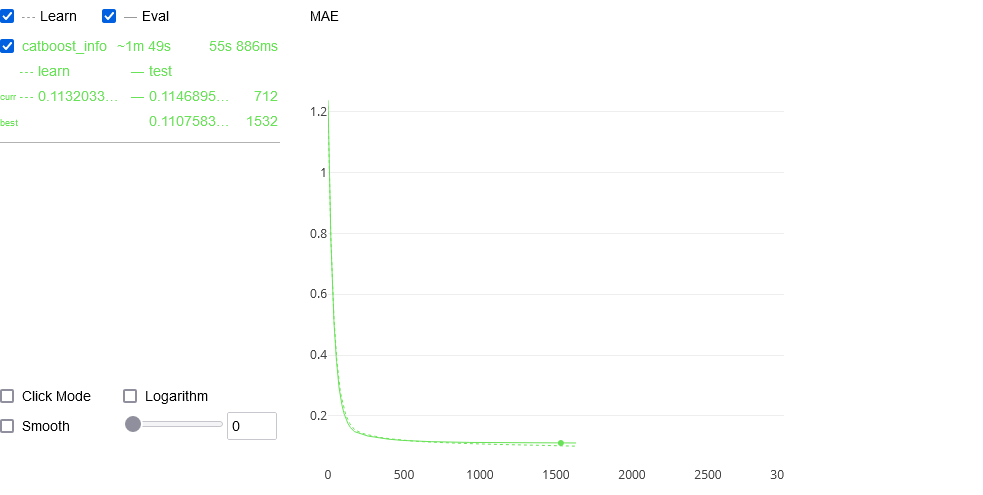

In [72]:
#display training plot
from IPython.display import Image
Image('images/plot1.png')

The model's performance stopped improving after 1532 iterations. Compared to when we trained with some categorical features, the performance is better. What variables and byhow much did they influence the model's performance?

In [73]:
# define the resulting features for the dataframe
features = list(num_cols)+list(cat_cols)

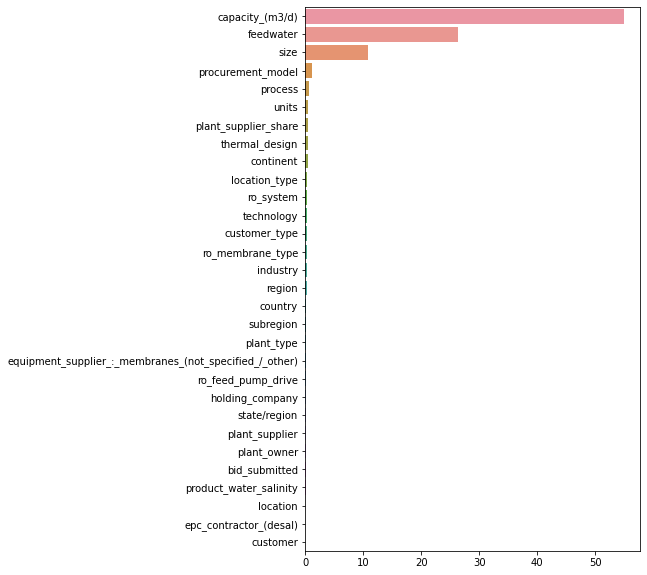

In [74]:
plt.figure(figsize=(6,10))
importances = sorted(list(zip(catboost.feature_importances_,features)),reverse=True)
x_axis = [x[0] for x in importances]
y_axis = [x[1] for x in importances]
sns.barplot(x=x_axis,y=y_axis);

- The high cardinality features didn't contribute so much to the model's performance 
- Most of the important features are the technical specifications of the plant. 
- The location variables do not strongly affect price
- `feedwater` appears to have a strong influence on price

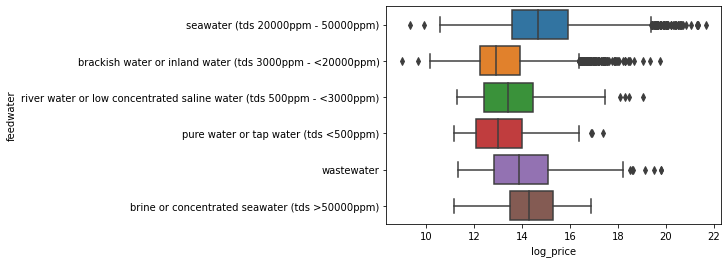

In [75]:
sns.boxplot(y='feedwater',x='log_price',data=df);

# Feature Engineering

We'll try to to improve the performance of our models by creating new features. These steps include:

- Combining related features
- Creating ordinal encoding for ordinal categorical features, such as `size`
- Some columns have multiple entries. We'll create new columns like `number of bidders` to indicate competition

In [76]:
!pip install country-list

In [77]:
from country_list import countries_for_language
# get a list of tuples of countries and abbreviations
countries = (countries_for_language('en'))
# convert keys and values to lowercase
countries = {k.lower():v.lower() for k,v in countries}

In [78]:
import re

def get_number(val_list):
    val_list = [val.strip() for val in val_list]
    i = 0
    if len(val_list) > 1:
        for val in val_list:
            if any([re.match(r'(inc|ltd|llc)[.]*',val), val in countries.keys(), val in countries.values()]):
                i = i+1
    return(len(val_list) - i)

In [79]:
def get_unique(df, col, sep):
    lists = df[col].str.split(sep)
    if sep==' / ':
        return lists.apply(len)
    return lists.apply(get_number)

In [80]:
cat_cols

Index(['country', 'region', 'subregion', 'location', 'state/region',
       'location_type', 'size', 'technology', 'process', 'thermal_design',
       'feedwater', 'customer_type', 'industry', 'customer', 'plant_type',
       'plant_supplier', 'procurement_model', 'epc_contractor_(desal)',
       'equipment_supplier_:_membranes_(not_specified_/_other)',
       'holding_company', 'plant_owner', 'bid_submitted', 'ro_system',
       'ro_feed_pump_drive', 'ro_membrane_type', 'continent'],
      dtype='object')

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

# define a custom transformer class to add the new features
class FeatureAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.feats = features
        
    # define the fit method that returns self
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.feats)
        # select high cardinality categorical columns
        self.high_card = [col for col in self.cat_cols if X_df[col].nunique() > 30]
        return self

    # define the transform method that adds the new features and returns the modified data frame
    def transform(self, X):
        # copy the input data frame
        df = pd.DataFrame(X, columns=self.feats)
        # seperate numerical data from categorical data
        X_num = df[self.num_cols]
        X_cat = df[self.cat_cols]

        # combine numerical features
        X_num['capacity_per_unit'] = X_num['capacity_(m3/d)']/X_num['units']

        # create ordinal variables
        X_num['size_ord'] = X_cat['size'].map({'s':1,'m':2,'l':3,'xl':4})

        X_num['feedwater_ord']=X_cat['feedwater'].map({'pure water or tap water (tds <500ppm)':1,
                                       'river water or low concentrated saline water (tds 500ppm - <3000ppm)':2,
                                        'brackish water or inland water (tds 3000ppm - <20000ppm)':3,
                                        'seawater (tds 20000ppm - 50000ppm)':4, 
                                        'brine or concentrated seawater (tds >50000ppm)':5,
                                        'wastewater':6})

        X_num['customer_type_ord']=X_cat['customer_type'].map({'industry (tds <10ppm)':1,
                                       'tourist facilities as drinking water (tds 10ppm - <1000ppm)':2,
                                       'municipalities as drinking water (tds 10ppm - <1000ppm)':2,
                                        'military purposes (tds 10ppm- <1000ppm)':2,
                                        'irrigation (tds <1000ppm)':2,
                                        'demonstration':3,
                                        'discharge':3})


        # create variable to indicate water quality
        X_num['quality'] = X_num['feedwater_ord']/X_num['customer_type_ord']

        # create counts
        for col in ['plant_supplier','bid_submitted']:
            X_num['num_'+col] = get_unique(X_cat,col,',')
        for col in ['epc_contractor_(desal)','equipment_supplier_:_membranes_(not_specified_/_other)']:
            X_num['num_'+col] = get_unique(X_cat,col,' / ')    

        # combine categorical features
        X_cat['region_type'] = X_cat['region'] + '_' + X_cat['location_type']
        X_cat['subregion_type'] = X_cat['subregion'] + '_' + X_cat['location_type']
        X_cat['continent_type'] = X_cat['continent'] + '_' + X_cat['location_type']
        X_cat['size_technology'] = X_cat['size'] + '_' + X_cat['technology']
        X_cat['technology_thermal'] = X_cat['technology'] + '_' + X_cat['thermal_design']
        X_cat['size_technology_thermal'] = X_cat['size'] + '_' + X_cat['technology_thermal']
        X_cat['ro_system_feed'] = X_cat['ro_system'] + '_' + X_cat['ro_feed_pump_drive']
        X_cat['ro_system_membrane'] = X_cat['ro_system'] + '_' + X_cat['ro_membrane_type']
        X_cat['ro_feed_membrane'] = X_cat['ro_feed_pump_drive'] + '_' + X_cat['ro_membrane_type']
        X_cat['ro_system_feed_membrane'] = X_cat['ro_system'] + '_' + X_cat['ro_feed_pump_drive'] + '_' + X_cat['ro_membrane_type']
        X_cat['size_ro'] = X_cat['size'] + '_' + X_cat['ro_system_feed_membrane']
        X_cat['size_type'] = X_cat['size'] + '_' + X_cat['plant_type']
        X_cat['size_model'] = X_cat['size'] + '_' + X_cat['procurement_model']
        X_cat['type_model'] = X_cat['plant_type'] + '_' + X_cat['procurement_model']
        X_cat['size_type_model'] = X_cat['size'] + '_' + X_cat['type_model']

        # create indicator variables
        X_num['plant_supplier_contractor'] = (X_cat['plant_supplier']==X_cat['epc_contractor_(desal)']).astype(int)
        X_num['plant_equipment_supplier'] = (X_cat['plant_supplier']==X_cat['equipment_supplier_:_membranes_(not_specified_/_other)']).astype(int)
        X_num['plant_supplier_holder'] = (X_cat['plant_supplier']==X_cat['holding_company']).astype(int)
        X_num['plant_supplier_bidder'] = (X_cat['plant_supplier']==X_cat['bid_submitted']).astype(int)
        X_num['equi_supplier_contractor'] = (X_cat['equipment_supplier_:_membranes_(not_specified_/_other)']==X_cat['epc_contractor_(desal)']).astype(int)
        X_num['equi_supplier_holder'] = (X_cat['equipment_supplier_:_membranes_(not_specified_/_other)']==X_cat['holding_company']).astype(int)
        X_num['equi_supplier_bidder'] = (X_cat['equipment_supplier_:_membranes_(not_specified_/_other)']==X_cat['bid_submitted']).astype(int)
        X_num['contractor_holder'] = (X_cat['epc_contractor_(desal)']==X_cat['holding_company']).astype(int)
        X_num['contractor_bidder'] = (X_cat['epc_contractor_(desal)']==X_cat['bid_submitted']).astype(int)
        X_num['holder_bidder'] = (X_cat['holding_company']==X_cat['bid_submitted']).astype(int)

        # drop size, feedwater, and customer_type
        X_cat.drop(['size', 'feedwater', 'customer_type'],axis=1, inplace=True)
        
        # ensure numeric columns are numeric
        for col in X_num.columns:
            X_num[col] = X_num[col].astype(float)
        
        # drop high cardinality columns
        include = [col for col in X_cat.columns if col not in self.high_card]
        df = pd.concat([X_num,X_cat[include]],axis=1)
        return df

In [82]:
# create pipeline to impute, encode and add features
preprocessor = make_pipeline(ColumnTransformer(
                                    transformers=[
                                    ("num_impute_scale", Pipeline(steps=[("impute", num_imputer), 
                                                                         ("scale", scaler)]), num_cols),
                                    ("cat_impute", cat_imputer, cat_cols)]), 
                              FeatureAdder())

In [83]:
a = preprocessor.fit_transform(X_train)
a.head(3)

,capacity_(m3/d),units,plant_supplier_share,product_water_salinity,capacity_per_unit,size_ord,feedwater_ord,customer_type_ord,quality,num_plant_supplier,num_bid_submitted,num_epc_contractor_(desal),num_equipment_supplier_:_membranes_(not_specified_/_other),plant_supplier_contractor,plant_equipment_supplier,plant_supplier_holder,plant_supplier_bidder,equi_supplier_contractor,equi_supplier_holder,equi_supplier_bidder,contractor_holder,contractor_bidder,holder_bidder,region,subregion,location_type,technology,process,thermal_design,industry,plant_type,procurement_model,ro_system,ro_feed_pump_drive,ro_membrane_type,continent,region_type,subregion_type,continent_type,size_technology,technology_thermal,size_technology_thermal,ro_system_feed,ro_system_membrane,ro_feed_membrane,ro_system_feed_membrane,size_ro,size_type,size_model,type_model,size_type_model
0,-0.163161,-0.095305,0.156561,-0.068234,1.711982,1.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,emea,middle east / north africa,land based,med (multi-effect distillation),Thermal,flash,oil & gas,stand-alone,epc,N/A,N/A,N/A,AS,emea_land based,middle east / north africa_land based,AS_land based,s_med (multi-effect distillation),med (multi-effect distillation)_flash,s_med (multi-effect distillation)_flash,N/A_N/A,N/A_N/A,N/A_N/A,N/A_N/A_N/A,s_N/A_N/A_N/A,s_stand-alone,s_epc,stand-alone_epc,s_stand-alone_epc
1,-0.144754,-0.095305,0.156561,-0.068234,1.518849,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,emea,eastern europe / central asia,land based,ro (reverse osmosis),Membrane,N/A,power,stand-alone,epc,single pass,electric motor,spiral wound membrane,EU,emea_land based,eastern europe / central asia_land based,EU_land based,s_ro (reverse osmosis),ro (reverse osmosis)_N/A,s_ro (reverse osmosis)_N/A,single pass_electric motor,single pass_spiral wound membrane,electric motor_spiral wound membrane,single pass_electric motor_spiral wound membrane,s_single pass_electric motor_spiral wound memb...,s_stand-alone,s_epc,stand-alone_epc,s_stand-alone_epc
2,3.596954,0.401900,0.156561,-0.068234,8.949876,4.0,4.0,2.0,2.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,emea,middle east / north africa,land based,msf (multi-stage flash),Thermal,flash,power,stand-alone,epc,N/A,N/A,N/A,AS,emea_land based,middle east / north africa_land based,AS_land based,xl_msf (multi-stage flash),msf (multi-stage flash)_flash,xl_msf (multi-stage flash)_flash,N/A_N/A,N/A_N/A,N/A_N/A,N/A_N/A_N/A,xl_N/A_N/A_N/A,xl_stand-alone,xl_epc,stand-alone_epc,xl_stand-alone_epc


In [84]:
# define list of columns to encode
to_encode = a.select_dtypes(include='O').columns

# define encoder
encoder = OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)

# define another preprocessor to encode categories
preprocessor2 = make_pipeline(preprocessor,
                              ColumnTransformer(
                                    transformers=[("encode", encoder,to_encode)], 
                                    remainder='passthrough'))

In [85]:
for model in models:

    # Create a pipeline with the preprocessor and model
    pipe = make_pipeline(preprocessor2, model)

    # Perform cross-validation on the pipeline
    scores = -(cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
    print(f'{model.__class__.__name__}: {np.mean(scores)}') 

LinearRegression: 176645642.69960198
Lasso: 1.2623160280667751
DecisionTreeRegressor: 0.1725947009595477
RandomForestRegressor: 0.14793679103472696
ExtraTreesRegressor: 0.14880213816882115
GradientBoostingRegressor: 0.15638126626590917
AdaBoostRegressor: 0.42186113104595624
XGBRegressor: 0.1609351265611525
LGBMRegressor: 0.15056751477108418
CatBoostRegressor: 0.15153101567197588


The new features barely improved the models. We'll stick with the inital `CatBoostRegressor` model

# Feature Selection

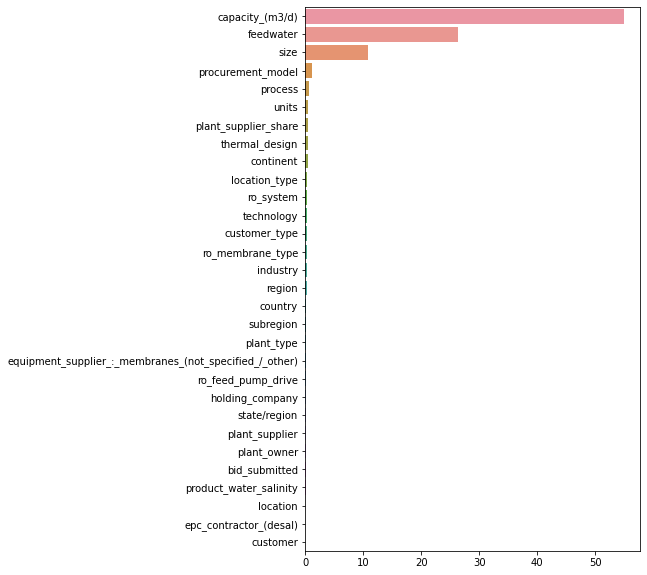

In [86]:
plt.figure(figsize=(6,10))
importances = sorted(list(zip(catboost.feature_importances_,features)),reverse=True)
x_axis = [x[0] for x in importances]
y_axis = [x[1] for x in importances]
sns.barplot(x=x_axis,y=y_axis);

We'll retrain and evaluate the `CatBoostRegressor` model using the top 14 most important features.

In [87]:
# select top 14 most important features
top_14 = y_axis[:14]

# reduce data frames
X_train_reduced = X_train[top_14]
X_val_reduced = X_val[top_14]
X_test_reduced = X_test[top_14]

# seperate numerical columns from categorical ones
num_cols = list(X_train_reduced.select_dtypes(exclude='O').columns)
cat_cols = list(X_train_reduced.select_dtypes(include='O').columns)

In [88]:
from resources.my_transformers import CatImputer

In [89]:
# define imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = CatImputer()

# define scaler
scaler = StandardScaler()

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_impute_scale", Pipeline(steps=[("impute", num_imputer), ("scale", scaler)]), num_cols),
        ("cat_impute", cat_imputer, cat_cols)])

In [90]:
#preprocess val and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train_reduced)
X_val_preprocessed = preprocessor.transform(X_val_reduced)
X_test_preprocessed = preprocessor.transform(X_test_reduced)

In [91]:
# refit model
cat_indices = list(range(3,14))
catboost = CatBoostRegressor(iterations=3000,loss_function='MAE',random_seed=42,logging_level='Silent',
                          learning_rate=0.1,use_best_model=True)
catboost.fit(X=X_train_preprocessed, y=y_train, cat_features=cat_indices,
         eval_set=(X_val_preprocessed,y_val),early_stopping_rounds=100,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

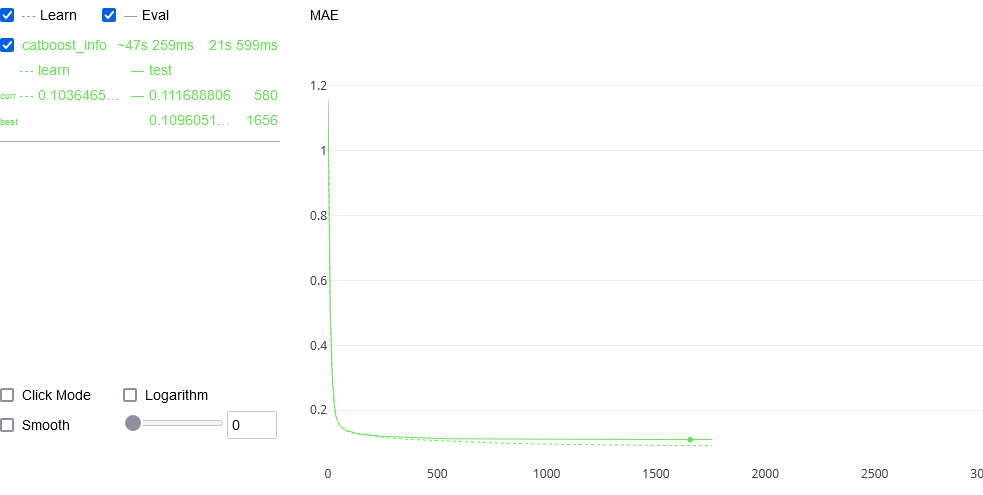

In [92]:
#display training plot
from IPython.display import Image
Image('images/plot2.png')

In [93]:
#evaluate mae on validation set
val_preds = np.expm1(catboost.predict(X_val_preprocessed))
y_true = np.expm1(y_val)
mae(y_true,val_preds)

2412805.695217271

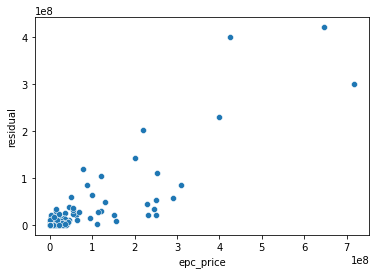

In [94]:
val_preds = np.expm1(catboost.predict(X_val_preprocessed))
y_true = np.expm1(y_val)
residuals = abs(val_preds - y_true)
sns.scatterplot(y_true,residuals)
plt.xlabel('epc_price')
plt.ylabel('residual');

The nodel makes large errors on large plants and vice versa. This could be because of the underrepresentation of large plants in the data set

In [95]:
X_train['size'].value_counts(normalize=True)*100

s     62.441119
m     30.382377
l      5.126074
xl     2.050429
Name: size, dtype: float64

In [96]:
#evaluate mae on test set
test_preds = np.expm1(catboost.predict(X_test_preprocessed))
y_true = np.expm1(y_test)
mae(y_true,test_preds)

2348782.313974501

In [97]:
# pickle the final model and preprocessor
import pickle

pickle.dump(catboost,open('resources/model.pkl','wb'))
pickle.dump(preprocessor,open('resources/preprocessor.pkl','wb'))